In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import naludaq
print(f"Naludaq version: {naludaq.__version__}")

Naludaq version: 0.31.7


In [231]:
from naludaq.backend import DiskAcquisition

ACQ_PATH = "data/SineWave_100MHz/"
channels = 4
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH) as acq:
    print("Board model:", acq.params["model"])
    print("Number of events:", len(acq))
    print("Pedestals stored:", acq.pedestals is not None)

acq= DiskAcquisition(ACQ_PATH)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals=acq.pedestals
params = acq.params
corrector = PedestalsCorrecter(params, pedestals)

Board model: dsa-c10-8
Number of events: 1013
Pedestals stored: True


In [184]:
def find_ampl(data, thr=3000):
    cell_ampl = []
    for j in range(len(data)): 
        diff = np.max(data[j]) - np.min(data[j]) 
        if diff < thr:
            cell_ampl.append(diff)
        
    # plt.hist(cell_ampl, bins=20);
    # plt.xlabel('Amplitude [ADC]')
    # plt.ylabel('Frequency')

    amplitude = np.mean(cell_ampl)
    print(f"Amplitude [ADC]: {amplitude:.2f}")
    return amplitude


def find_min_amp(data):
    cell_min= []
    for i in range(len(data)):
        cell_min.append(np.min(data[i]))

    min_amp = np.mean(cell_min)
    return min_amp

## Consider the starting cell (added later)

In [232]:
num_cells = 128
cell_data = {i: [] for i in range(num_cells)}  # Initialize storage for each cell

for ev_num in range(len(acq)):
    event=acq[ev_num]
    corrected_event = corrector.run(event, correct_in_place=True)
    start_window = event['start_window'] % num_cells 
    adc_values=corrected_event["data"]    
    
    for i in range(1024):
        cell = (start_window + i) % num_cells  # Compute actual cell index
        cell_data[cell].append(adc_values[4][i])  


print(cell_data[0])

[-243.70000000000005, -107.0, 1052.1, -331.5999999999999, -401.0, 730.3, 477.0999999999999, 510.29999999999995, -253.79999999999995, -317.4000000000001, 1642.1, 866.5999999999999, -595.0, 392.4000000000001, 1740.6, -8.099999999999909, -428.70000000000005, 1317.7, 1156.1, -534.2, 114.90000000000009, 1769.3, 406.20000000000005, -566.0999999999999, -345.70000000000005, 1583.0, 896.5999999999999, -599.0, 255.20000000000005, 1737.9, 16.40000000000009, -469.20000000000005, 15.799999999999955, 1809.1, 445.70000000000005, -580.7, 897.0999999999999, 1490.9, -389.4000000000001, -233.29999999999995, 970.5, 1359.2, -432.20000000000005, -189.0999999999999, 1688.3, 590.7, -599.4000000000001, 629.4000000000001, 313.4000000000001, -496.9000000000001, 1133.0, 1317.5, -459.0, -28.09999999999991, 1743.4, 511.29999999999995, -500.4000000000001, 1207.0, 1229.8, -487.0, 10.5, 1750.2, 469.0, -565.9000000000001, 391.0999999999999, 1700.2, -67.5, -394.5, 1417.0, 1072.3, -544.9000000000001, 183.0, 1676.2, 946.4

128
9.119020910075728


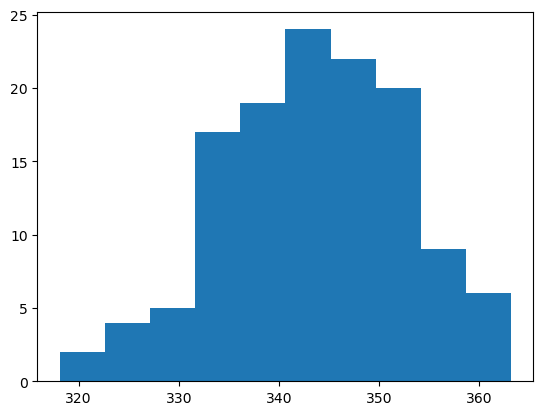

In [241]:
cell_offset = []
for i in range(len(cell_data)):
    cell_offset.append(np.median(cell_data[i]))
plt.hist(cell_offset, bins=10);  

cell_offset_mean = np.mean(cell_offset)
print(np.std(cell_offset))

In [187]:
for cell in range(num_cells):
    cell_data[cell] = np.array(cell_data[cell]) - cell_offset[cell]  

348.5999999999999


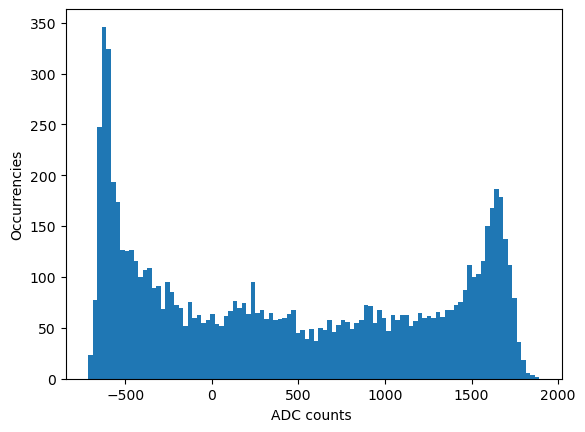

In [240]:
plt.hist(cell_data[111],bins=100);
plt.xlabel("ADC counts ")
plt.ylabel("Occurrencies")
print(np.median(cell_data[111]))

## Now we want to plot for each of the 128 cells its ADC count distribution

In [189]:
# cell_ADC_value = np.zeros((len(acq), 128, 8))

# for ev in range(len(acq)):
#     event=acq[ev]
#     corrected_event = corrector.run(event, correct_in_place=True)
#     time=corrected_event["time"]
#     adc=corrected_event["data"]
#     cell_ADC_value[ev] = adc[4].reshape(8,128).T

In [190]:
# single_cell_distrib = np.zeros((128, 8104))
# for i in range(128):
#     single_cell_distrib[i] = cell_ADC_value[:,i,:].flatten()
# print(single_cell_distrib.shape)

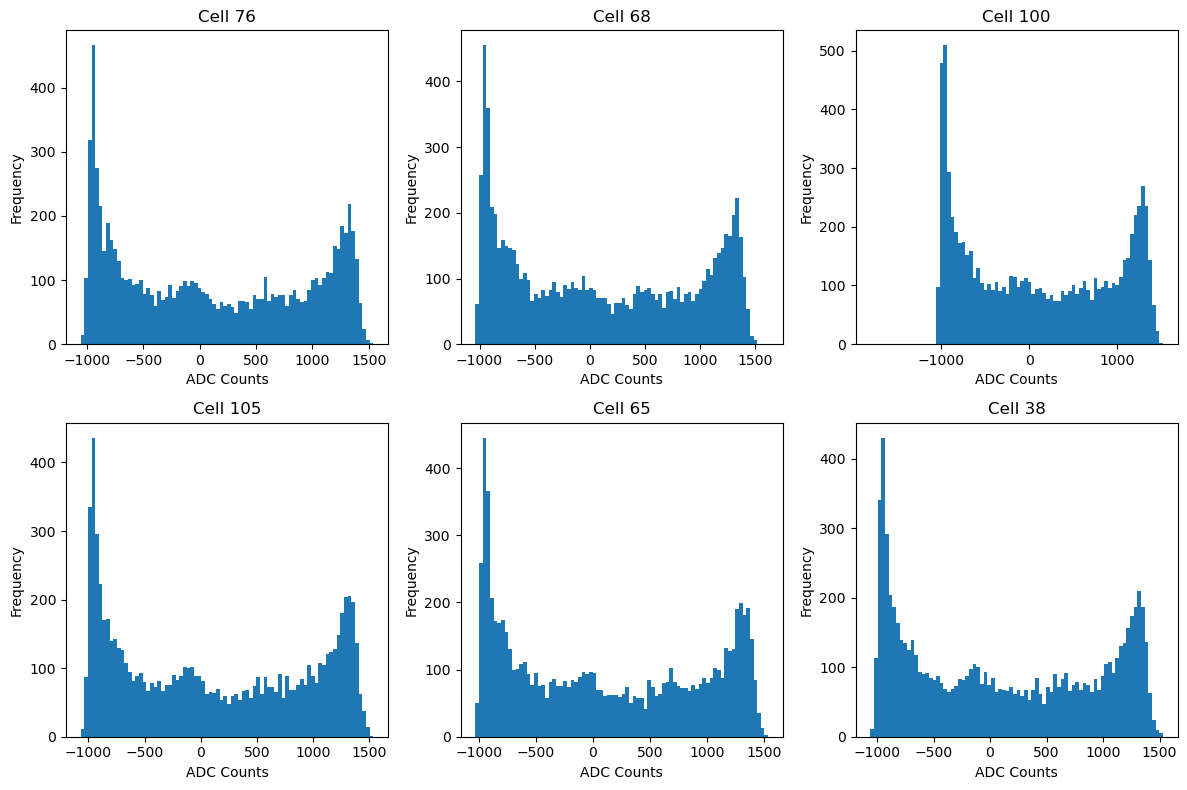

In [191]:
random_indices = np.random.choice(128, 6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Plot the histograms for the randomly selected indices
for i, idx in enumerate(random_indices):
    axes[i].hist(cell_data[idx], bins=80)
    axes[i].set_title(f"Cell {idx}")
    axes[i].set_xlabel('ADC Counts')
    axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## From this analysis we need to obtain offset and amplitude

* Let's start with the offset

* Now let's have look at the amplitude...   Mhh this doesn't convince me, I'm making some mistake

In [192]:
find_ampl(cell_data, 2700)

Amplitude [ADC]: 2596.98


2596.9823529411765

* Just a check on a single event adc distribution $\rightarrow$ same as we got after the data analysis

Event number: 219


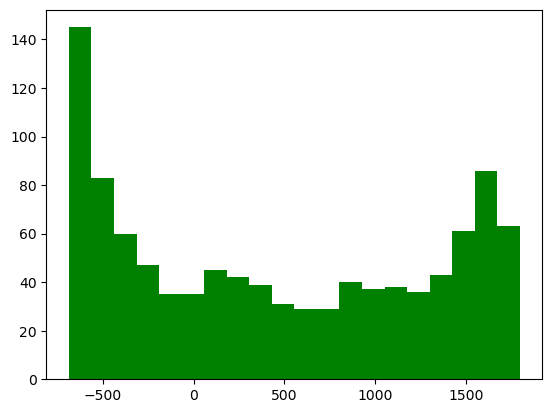

In [193]:
event_num = 219
print("Event number: {}".format(event_num))
event=acq[event_num]
corrected_event = corrector.run(event, correct_in_place=True)
time=corrected_event["time"]
adc=corrected_event["data"]
plt.hist(adc[4],bins=20, color='green');

## Let's look at the ideal distribution

Event number: 586
Fitted parameters: A=1169.924, f=0.100, phi=-0.782, C=433.035


Text(0, 0.5, 'ADC Count')

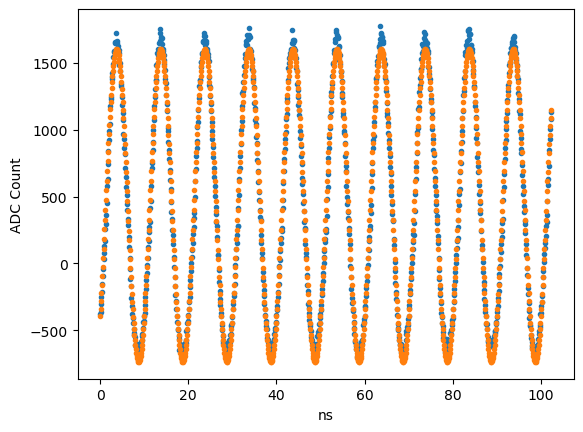

In [194]:
from scipy.optimize import curve_fit

event_num = 586
print("Event number: {}".format(event_num))
event=acq[event_num]
corrected_event = corrector.run(event, correct_in_place=True)
time=corrected_event["time"]
adc=corrected_event["data"]
time_adjusted = time[4] - time[4][0]
time_adjusted = time_adjusted * 0.1

def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c

p, _ = curve_fit(sinewave, time_adjusted, adc[4], p0=[2500, 0.1, 0, 0])

A_fit, f_fit, phi_fit, C_fit = p
print(f"Fitted parameters: A={A_fit:.3f}, f={f_fit:.3f}, phi={phi_fit:.3f}, C={C_fit:.3f}")
fitx = np.linspace(time_adjusted[0], time_adjusted[-1], 1024)
plt.plot(time_adjusted, adc[4], '.', label="Data")
plt.plot(fitx, sinewave(fitx, *p), '.', label="Fit")
plt.xlabel("ns")
plt.ylabel("ADC Count")

## Now we look at different sinewave data, with different amplitudes

In [195]:
ACQ_PATH1 = "data/Voltage_100mV/"
ACQ_PATH2 = "data/Voltage_200mV/"
ACQ_PATH3 = "data/Voltage_300mV/"
channels = 4
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH1) as acq1:
    print("Board model:", acq1.params["model"])
    print("Number of events:", len(acq1))
    print("Pedestals stored:", acq1.pedestals is not None)
with DiskAcquisition(ACQ_PATH2) as acq2:
    print("Board model:", acq2.params["model"])
    print("Number of events:", len(acq2))
    print("Pedestals stored:", acq2.pedestals is not None)
with DiskAcquisition(ACQ_PATH3) as acq3:
    print("Board model:", acq3.params["model"])
    print("Number of events:", len(acq3))
    print("Pedestals stored:", acq3.pedestals is not None)

acq1= DiskAcquisition(ACQ_PATH1)
acq2= DiskAcquisition(ACQ_PATH2)
acq3= DiskAcquisition(ACQ_PATH3)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals1=acq1.pedestals
params1 = acq1.params
corrector1 = PedestalsCorrecter(params1, pedestals1)

pedestals2=acq2.pedestals
params2 = acq2.params
corrector2 = PedestalsCorrecter(params2, pedestals2)

pedestals3=acq3.pedestals
params3 = acq3.params
corrector3 = PedestalsCorrecter(params3, pedestals3)

Board model: dsa-c10-8
Number of events: 222
Pedestals stored: True
Board model: dsa-c10-8
Number of events: 280
Pedestals stored: True
Board model: dsa-c10-8
Number of events: 304
Pedestals stored: True


* 100 mV

345.616015625


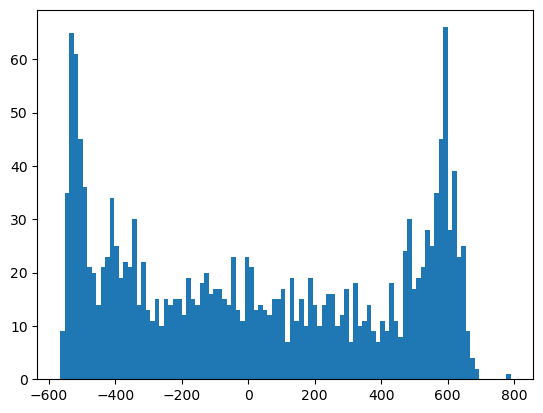

In [196]:
num_cells = 128
cell_data1 = {i: [] for i in range(num_cells)}  # Initialize storage for each cell

for ev_num in range(len(acq1)):
    event1=acq1[ev_num]
    corrected_event1 = corrector1.run(event1, correct_in_place=True)
    start_window1 = event1['start_window'] % num_cells 
    adc_values1=corrected_event1["data"]    
    
    for i in range(1024):
        cell1 = (start_window1 + i) % num_cells  # Compute actual cell index
        cell_data1[cell1].append(adc_values1[4][i])  

cell_offset1 = []
for i in range(len(cell_data1)):
    cell_offset1.append(np.median(cell_data1[i]))

cell_offset1_mean = np.mean(cell_offset1)
print(cell_offset1_mean)

for cell in range(num_cells):
    cell_data1[cell] = np.array(cell_data1[cell]) - cell_offset1[cell]  

plt.hist(cell_data1[20],bins=100);

In [197]:
find_ampl(cell_data1, 2000)

Amplitude [ADC]: 1303.96


1303.9604838709681

* 200 mV

339.23359375000007


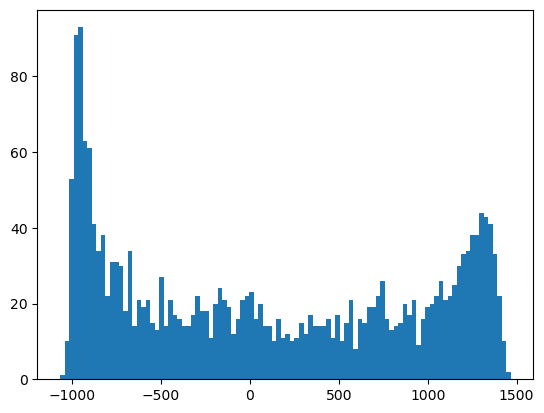

In [198]:
num_cells = 128
cell_data2 = {i: [] for i in range(num_cells)}  # Initialize storage for each cell

for ev_num in range(len(acq2)):
    event2=acq2[ev_num]
    corrected_event2 = corrector2.run(event2, correct_in_place=True)
    start_window2 = event2['start_window'] % num_cells 
    adc_values2=corrected_event2["data"]    
    
    for i in range(1024):
        cell2 = (start_window2 + i) % num_cells  # Compute actual cell index
        cell_data2[cell2].append(adc_values2[4][i])  

cell_offset2 = []
for i in range(len(cell_data2)):
    cell_offset2.append(np.median(cell_data2[i]))

cell_offset2_mean = np.mean(cell_offset2)
print(cell_offset2_mean)

for cell in range(num_cells):
    cell_data2[cell] = np.array(cell_data2[cell]) - cell_offset2[cell]  

plt.hist(cell_data2[45],bins=100);

In [199]:
find_ampl(cell_data2)

Amplitude [ADC]: 2522.51


2522.506557377049

* 300 mV

312.92421875


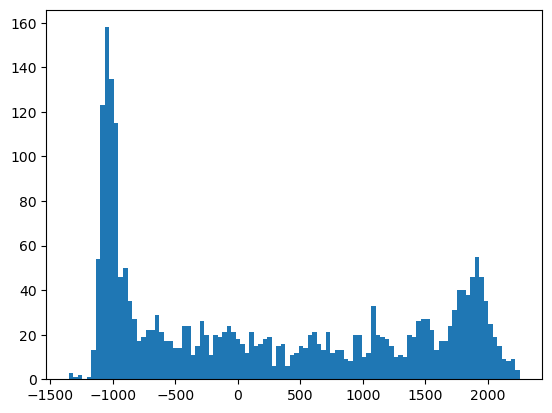

In [200]:
num_cells = 128
cell_data3 = {i: [] for i in range(num_cells)}  # Initialize storage for each cell

for ev_num in range(len(acq3)):
    event3=acq3[ev_num]
    corrected_event3 = corrector3.run(event3, correct_in_place=True)
    start_window3 = event3['start_window'] % num_cells 
    adc_values3=corrected_event3["data"]    
    
    for i in range(1024):
        cell3 = (start_window3 + i) % num_cells  # Compute actual cell index
        if adc_values3[4][i] > -1050:
            cell_data3[cell3].append(adc_values3[4][i])  

cell_offset3 = []
for i in range(len(cell_data3)):
    cell_offset3.append(np.median(cell_data3[i]))

cell_offset3_mean = np.mean(cell_offset3)
print(cell_offset3_mean)

for cell in range(num_cells):
    cell_data3[cell] = np.array(cell_data3[cell]) - cell_offset3[cell]  

plt.hist(cell_data3[85],bins=100);
# print(np.median(cell_data3[0]))

In [201]:
find_ampl(cell_data3, 5000)

Amplitude [ADC]: 3577.25


3577.2515625

## Now, take into consideration only the first half of the amplitude (distribution) that should be quite linear (the second half is not)

* Do this for each cell $\longrightarrow$ one for all doesn't make sense

[48.67170427 26.81341819  9.11902091 26.81341819 48.67170427 55.58086832]


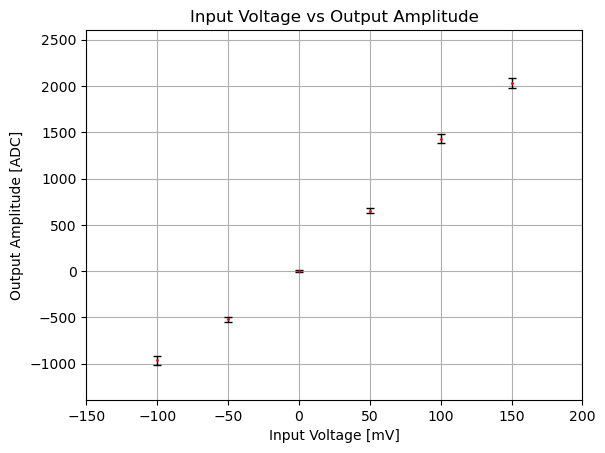

In [202]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Gaussian function for fitting
def gaussian(x, mu, sigma, A):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

def fit_gaussian_around_peak(bin_centres, counts, peak_idx, window=4):
    """ Fits a Gaussian to bins around the detected peak """
    if peak_idx is None:
        return None, None

    # Define fitting range
    start = max(0, peak_idx - window)
    end = min(len(bin_centres), peak_idx + window + 1)
    
    x_fit = bin_centres[start:end]
    y_fit = counts[start:end]

    if len(x_fit) < 5:  # Ensure we have enough points to fit
        return None, None

    # Initial estimates: peak position, width, amplitude
    p0 = [bin_centres[peak_idx], np.std(x_fit), max(y_fit)]
    
    try:
        params, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        mu, sigma, _ = params
        return mu, sigma
    except RuntimeError:
        return None, None

n_cell = 99
in_adc = [-100, -50, 0, 50, 100, 150]
out_adc = np.zeros((128, 6))
err_bars = np.zeros((128, 6))
sigmas = [] 

for j in range(128):
    # Compute histograms
    histograms = [np.histogram(cell_data[j], bins=100),
                  np.histogram(cell_data1[j], bins=100),
                  np.histogram(cell_data3[j], bins=100)]

    # Extract counts and bin centres
    counts_list = [h[0] for h in histograms]
    bin_centres_list = [(h[1][:-1] + h[1][1:]) / 2 for h in histograms]
    
    # Evaluate lowest value of the amplitude
    peak_values = []
    peak_errors = []

    for counts, bin_centres in zip(counts_list, bin_centres_list):
        peaks, _ = find_peaks(counts)
    
        # Select the highest negative peak
        peak_idx = None
        sorted_peaks = sorted(peaks, key=lambda p: counts[p], reverse=True)
        for p in sorted_peaks:
            if bin_centres[p] < 0:
                peak_idx = p
                break

        mu, sigma = fit_gaussian_around_peak(bin_centres, counts, peak_idx)
    
        peak_values.append(mu if mu is not None else bin_centres[peak_idx])
        peak_errors.append(sigma if sigma is not None else 0)
    
    sigmas.append(peak_errors[0])
    # Evaluate highest amplitude value
    highest_adc = []
    highest_adc_errors = []

    for bin_centres, counts in zip(bin_centres_list, counts_list):
        # Select bins where counts > 20
        selected_bins = bin_centres[counts > 20]

        if len(selected_bins) > 0:
            max_adc = max(selected_bins)  
            max_adc_index = list(bin_centres).index(max_adc)  
            error = np.sqrt(counts[max_adc_index])
        else:
            max_adc, error = None, None  

        highest_adc.append(max_adc)
        highest_adc_errors.append(error)
    
    # Store results in out_adc
    out_adc[j] = [peak_values[0], peak_values[1], np.median(cell_data[j]),
                  highest_adc[1], highest_adc[0], highest_adc[2]]
    
    # print(peak_errors)
    err_bars[j] = [peak_errors[0], peak_errors[1], np.std(cell_offset),
                   peak_errors[1], peak_errors[0], peak_errors[2]]

# Scatter plot with error bars for a specific cell
plt.errorbar(
    in_adc, 
    out_adc[n_cell], 
    yerr=err_bars[n_cell],  
    fmt='o',               
    markersize=1,         
    color='red', 
    ecolor='black',         
    elinewidth=1,         
    capsize=3,             
    label='Data Points'
)
plt.xlim(-150, 200)
plt.ylim(np.min(cell_data[n_cell]) - 300, np.max(cell_data3[n_cell]) + 300)
plt.xlabel('Input Voltage [mV]')
plt.ylabel('Output Amplitude [ADC]')
plt.title('Input Voltage vs Output Amplitude')
plt.grid()

print(err_bars[n_cell])

[49.23625051520925, 49.56535692682734, 50.29393193777639, 57.98931622290969, 46.383867256923146, 53.76598654545645, 51.01573794270041, 64.31124249071556, 50.82421271019404, 55.916150537882274, 47.68850948885227, 47.16292577895518, 46.204844391846706, 48.120398485967776, 58.19427574746189, 49.66809719942233, 47.84566855229159, 54.30532181723019, 55.774163648129274, 51.288333964688874, 46.66001225233894, 51.41795392879504, 58.92277539402617, 54.90380082146557, 54.29700212892799, 53.286618465397964, 50.572692340136086, 53.56694997811734, 52.10048703133196, 50.73269628624101, 55.23467103010291, 49.945196521761005, 55.01582125036953, 55.09650096803934, 55.49055765252484, 56.36644126038535, 54.702966261780674, 52.31837810072027, 52.66177001332628, 47.131848735016106, 48.20357283723089, 46.1294224723772, 52.95137012714631, 53.540251883069715, 47.95826533055896, 53.288716371660996, 53.96766972618317, 49.61557527906998, 46.61517454443673, 51.7451015268694, 49.58495626031106, 52.23266461203948, 

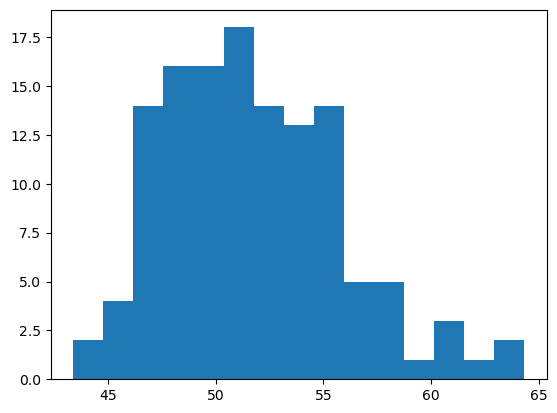

In [203]:
print(sigmas)
plt.hist(sigmas, bins=15);

In [204]:
# for i, (bin_centres, counts) in enumerate(zip(bin_centres_list, counts_list)):
#     # Select bins where counts > 5
#     selected_bins = bin_centres[counts > 5]
#     selected_counts = counts[counts > 5]

#     # Find the max ADC value in the selected bins
#     if len(selected_bins) > 0:
#         max_adc = max(selected_bins)
#     else:
#         max_adc = None  # Handle cases where no bin meets the threshold

#     # Print all selected bin centres and their counts
#     print(f"\nHistogram {i+1}:")
#     for bin_centre, count in zip(selected_bins, selected_counts):
#         print(f"Bin Centre: {bin_centre}, Count: {count}")

#     # Print the highest ADC value
#     print(f"Highest ADC in Histogram {i+1}: {max_adc}")

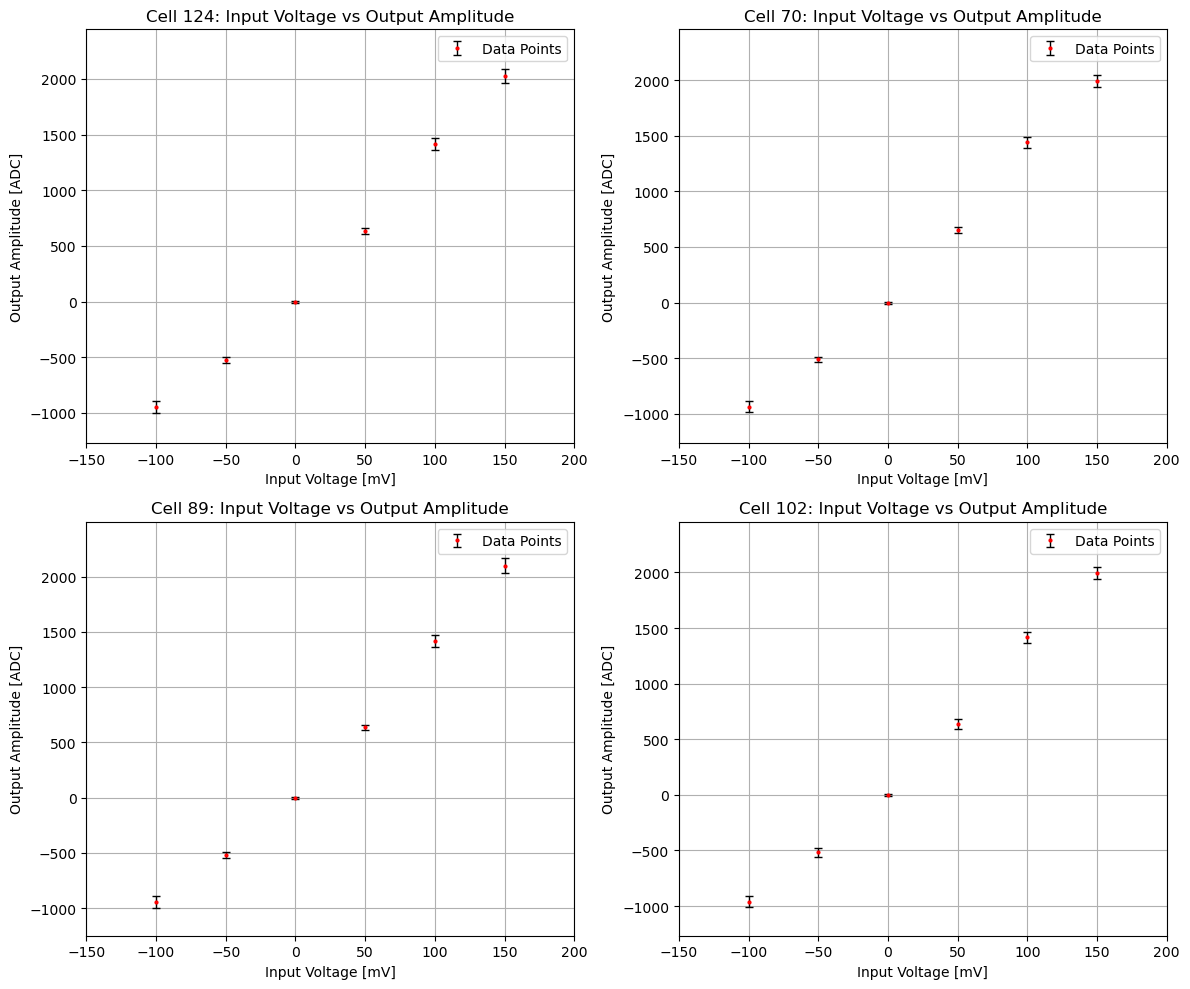

In [205]:
import random

random_cells = random.sample(range(128), 4)

# Create a 2×2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    numb_cell = random_cells[i]  # Selected cell

    # Scatter plot with error bars for the selected cell
    ax.errorbar(
        in_adc, 
        out_adc[numb_cell], 
        yerr=err_bars[numb_cell],  
        fmt='o',               
        markersize=2,         
        color='red', 
        ecolor='black',        
        elinewidth=1,         
        capsize=3,             
        label='Data Points'
    )
    
    # Set limits
    ax.set_xlim(-150, 200)
    ax.set_ylim(np.min(cell_data[numb_cell]) - 200, np.max(cell_data3[numb_cell]) + 200)

    # Labels and title
    ax.set_xlabel('Input Voltage [mV]')
    ax.set_ylabel('Output Amplitude [ADC]')
    ax.set_title(f'Cell {numb_cell}: Input Voltage vs Output Amplitude')
    
    ax.grid()
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

* Let's fit a function considering errors as well

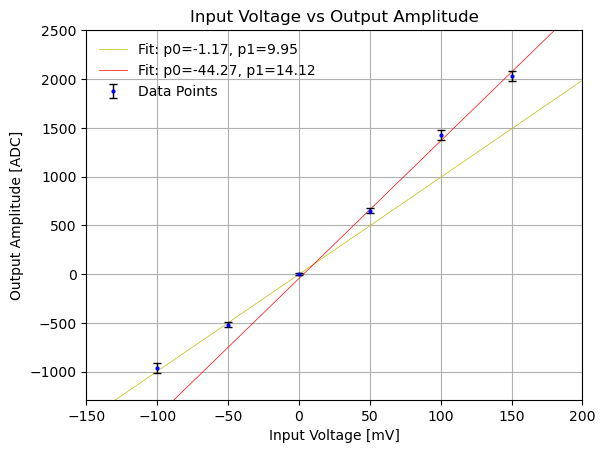

In [206]:
from scipy import optimize
from scipy import stats

x = np.linspace(-150, 200, 1000)

def pol1(x, p0, p1):
    return p0 + p1 * x

p, cov = optimize.curve_fit(pol1, in_adc[:3], out_adc[n_cell][:3], sigma=err_bars[n_cell][:3], absolute_sigma=True)
p1, cov1 = optimize.curve_fit(pol1, in_adc[3:], out_adc[n_cell][3:], sigma=err_bars[n_cell][3:], absolute_sigma=True)

plt.plot(x, pol1(x, *p), 'y-', linewidth=0.5, label='Fit: p0={:.2f}, p1={:.2f}'.format(p[0], p[1]))
plt.plot(x, pol1(x, *p1), 'r-', linewidth=0.5, label='Fit: p0={:.2f}, p1={:.2f}'.format(p1[0], p1[1]))

plt.errorbar(
    in_adc, 
    out_adc[n_cell], 
    yerr=err_bars[n_cell],  
    fmt='o',               
    markersize=2,         
    color='blue', 
    ecolor='black',         
    elinewidth=1,         
    capsize=3,             
    label='Data Points'
)

plt.xlim(-150, 200)
plt.ylim(np.min(cell_data[n_cell]) - 200, np.max(cell_data3[n_cell]) + 200)
plt.grid()
plt.xlabel('Input Voltage [mV]')
plt.ylabel('Output Amplitude [ADC]')
plt.title('Input Voltage vs Output Amplitude')
plt.legend(frameon=False);

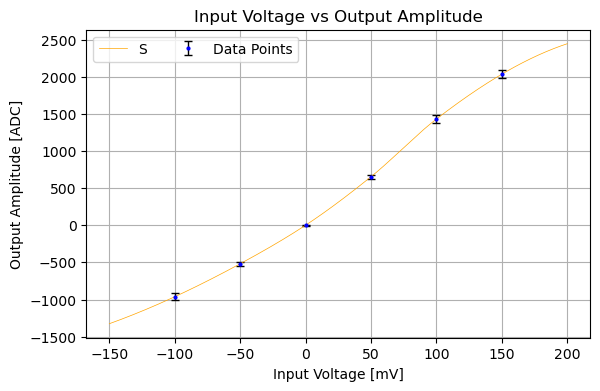

In [207]:
from scipy.interpolate import PchipInterpolator

cs = PchipInterpolator(in_adc, out_adc[n_cell])

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.errorbar(
    in_adc, 
    out_adc[n_cell], 
    yerr=err_bars[n_cell],  
    fmt='o',               
    markersize=2,         
    color='blue', 
    ecolor='black',         
    elinewidth=1,         
    capsize=3,             
    label='Data Points'
)
ax.plot(x, cs(x), color='orange', linewidth=0.5, label="S")

ax.legend(loc='upper left', ncol=2)
plt.xlabel('Input Voltage [mV]')
plt.ylabel('Output Amplitude [ADC]')
plt.title('Input Voltage vs Output Amplitude')
plt.grid()
plt.show()

$$
S_i(x) = a_i + b_i (x - x_i) + c_i (x - x_i)^2 + d_i (x - x_i)^3
$$

In [208]:
print("Spline coefficients (a, b, c, d) for each segment:")
for i in range(len(cs.x) - 1):
    print(f"Interval {cs.x[i]} ≤ x < {cs.x[i+1]}:")
    print(f"  a = {cs.c[3, i]}")
    print(f"  b = {cs.c[2, i]}")
    print(f"  c = {cs.c[1, i]}")
    print(f"  d = {cs.c[0, i]}")

Spline coefficients (a, b, c, d) for each segment:
Interval -100.0 ≤ x < -50.0:
  a = -962.6707288387742
  b = 8.128236972779202
  c = 0.016150944748092862
  d = -2.332483184014933e-05
Interval -50.0 ≤ x < 0.0:
  a = -518.7971223096006
  b = 9.568395208787367
  c = 0.008637593856696456
  d = 0.00015026701782792885
Interval 0.0 ≤ x < 50.0:
  a = 0.0
  b = 11.559157228166479
  c = 0.036764614746472725
  d = -0.00014017118619604645
Interval 50.0 ≤ x < 100.0:
  a = 652.348
  b = 14.184334806343402
  c = 0.09306691748660167
  d = -0.0013194922722693948
Interval 100.0 ≤ x < 150.0:
  a = 1429.2955
  b = 13.594834512983109
  c = -0.02591118051932444
  d = -8.647419480675608e-05


Fitted parameters: A=2704.672, B=0.005, C=-0.417, D=1066.794


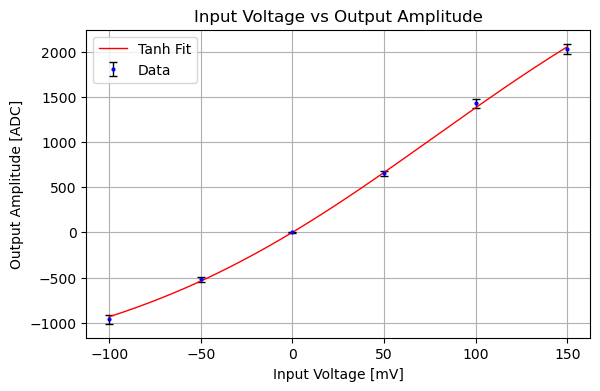

Chi-Squared: 2.255
Reduced Chi-Squared: 1.128


In [209]:
def tanh_fit(x, A, B, C, D):
    return A * np.tanh(B * x + C) + D

# Initial guesses for A, B, C, D (adjust as needed)
initial_guess = [3000, 0.01, 0, 100]

# Perform the curve fitting
params, covariance = curve_fit(tanh_fit, in_adc, out_adc[n_cell], p0=initial_guess, sigma=err_bars[n_cell], absolute_sigma=True)

# Extract the fitted parameters
A_fit, B_fit, C_fit, D_fit = params
print(f"Fitted parameters: A={A_fit:.3f}, B={B_fit:.3f}, C={C_fit:.3f}, D={D_fit:.3f}")

# Generate fitted values
x_fit = np.linspace(min(in_adc), max(in_adc), 200)
y_fit = tanh_fit(x_fit, *params)

# Plot data with error bars
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.errorbar(in_adc, out_adc[n_cell], yerr=err_bars[n_cell], fmt='o', markersize=2, color='blue', ecolor='black', elinewidth=1, capsize=3, label='Data')

# Plot the tanh fit
ax.plot(x_fit, y_fit, color='red', linewidth=1, label='Tanh Fit')

# Labels and legend
plt.xlabel('Input Voltage [mV]')
plt.ylabel('Output Amplitude [ADC]')
plt.title('Input Voltage vs Output Amplitude')
ax.legend()
ax.grid()
plt.show()

# Chi squared
in_adc = np.array(in_adc, dtype=np.float64)
out_adc[n_cell] = np.array(out_adc[n_cell], dtype=np.float64)
err_bars[n_cell] = np.array(err_bars[n_cell], dtype=np.float64)
chi2 = np.sum(((out_adc[n_cell] - tanh_fit(in_adc, *params)) / err_bars[n_cell])**2)
dof = len(in_adc) - len(params)  
reduced_chi2 = chi2 / dof

print(f"Chi-Squared: {chi2:.3f}")
print(f"Reduced Chi-Squared: {reduced_chi2:.3f}")

Let's try to convert the 6 output values I used as amplitudes

In [210]:
x_in = (np.arctanh((0 - D_fit) / A_fit) - C_fit) / B_fit
print(x_in)

-0.08608539364369755


-0.08608539364369755


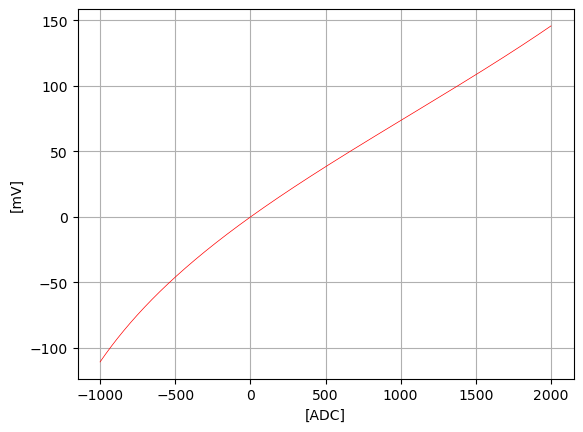

In [211]:
def voltage_corrector(x, *p):
    A_fit, B_fit, C_fit, D_fit = p
    return (np.arctanh((x - D_fit) / A_fit) - C_fit) / B_fit

adc_test = np.linspace(-1000, 2000, 3000)
mV_test = voltage_corrector(adc_test, *params)

plt.plot(adc_test, mV_test, 'r-', linewidth=0.5);
plt.xlabel('[ADC]')
plt.ylabel('[mV]')
plt.grid()
print(voltage_corrector(0, *params))

* Great! Now we've got to apply this function, with the correct prameters to each cell separately

In [229]:
param_array = np.zeros((128, 4))

for cell in range(128):
    p, cov = curve_fit(tanh_fit, in_adc, out_adc[cell], p0=initial_guess, sigma=err_bars[cell], absolute_sigma=True)
    param_array[cell] = p

print(param_array.shape)

(128, 4)


Now try to apply this correction to an example dataset.

(1024,)
197.88943713670474


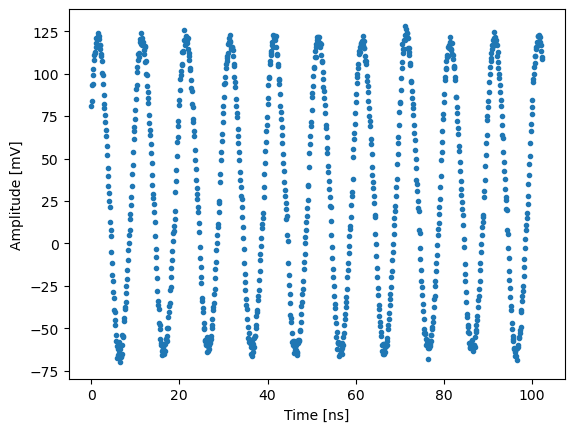

In [227]:
def mVconverter(x, p, N=1024):
    cell_indices = np.arange(N) % 128 
    A = p[cell_indices, 0]
    B = p[cell_indices, 1]
    C = p[cell_indices, 2]
    D = p[cell_indices, 3]
    return (np.arctanh((x - D) / A) - C) / B

# Apply correction: Element-wise operation per cell
adc_corrected = mVconverter(adc_values[4], param_array)

print(adc_corrected.shape) 
plt.plot(time_adjusted, adc_corrected, '.', label="Data");
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV]")
print(adc_corrected.max() - adc_corrected.min())

## Re-do the analysis with the corrected data

Just display an event from 300 mV sample

Event number: 219


Text(0, 0.5, 'ADC Count')

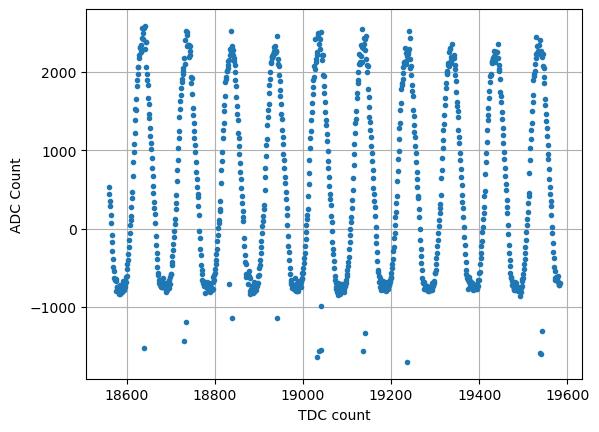

In [214]:
event_num = 219
print("Event number: {}".format(event_num))
event=acq3[event_num]
corrected_event = corrector3.run(event, correct_in_place=True)
time3=corrected_event["time"]
adc3=corrected_event["data"]
plt.plot(time3[4],adc3[4],'.',label="Ch. 4")
plt.grid()
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

## 'Real' ideal case
I misunderstood the ideal situation, should be easier than what I have done

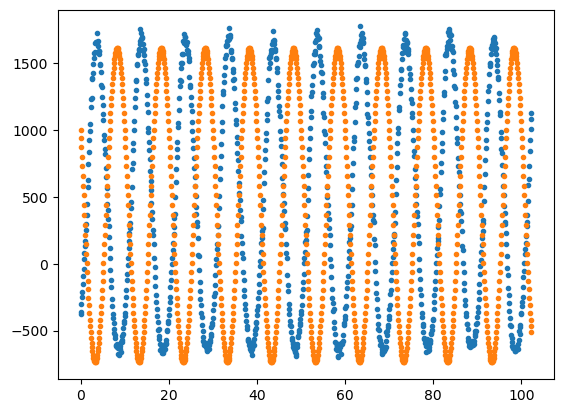

In [215]:
# A=-1176.498, f=0.100, phi=-0.503, C=437.690
x = np.linspace(0,102.3,1024)
y = sinewave(x, -1176.498, 0.1, -0.503, 437.690)
plt.plot(x, adc[4],'.')
plt.plot(x,y,'.')

* Checking linearity

In [216]:
adc_ideal_value  = []
for i in range(1024):
    adc_ideal_value.append(y[i])

print(adc_ideal_value)

[1004.8280668648936, 938.9859037540207, 871.1653547313443, 801.6340765195955, 730.6664773080565, 658.5426337888032, 585.5471858219563, 511.96821309219297, 438.0960981898424, 364.2223806034652, 290.6386061466834, 217.63517636004926, 145.50020242883585, 74.51836813981504, 4.96980636441009, -62.87100649776687, -128.73633375186836, -192.36623504222797, -253.50959221818943, -311.92510038272195, -367.38222021260725, -419.66208779182494, -468.5583783674394, -513.8781206191388, -555.4424582288768, -593.087355745047, -626.6642459554712, -656.0406162143104, -681.1005314089402, -701.7450915028735, -717.8928218490221, -729.4799947329059, -736.4608808768278, -738.8079299124415, -736.511879109468, -729.5817899314611, -718.0450122743493, -701.9470765288931, -681.3515138930327, -656.3396056432744, -627.0100623546252, -593.4786343350527, -555.8776548118972, -514.3555176730833, -469.0760918242382, -420.21807447298426, -367.9742858927032, -312.5509084490041, -254.1666728921246, -193.05199512658822, -129.

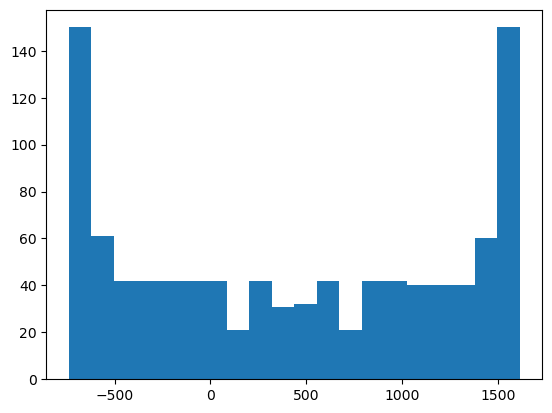

In [217]:
plt.hist(adc_ideal_value, bins= 20);

### Different phases (as it is in the data points)

In [218]:
phi_values = np.random.uniform(-np.pi, np.pi, 1000)
# phi_values = np.ones(1000)
# Create an empty array to store all sine waves
y = np.zeros((1000, 128, 8))

# Generate sine waves and store them in the array
for i, phi in enumerate(phi_values):
    sine = sinewave(x, 1200,  0.100,phi, 450)  # Generate sine wave
    y[i] = sine.reshape(8, 128).T  # Reshape and store

In [219]:
cell_offset_ideal = []
id_cell = np.zeros((128, 8000))
for i in range(128):
    id_cell[i] = y[:,i,:].flatten()
    cell_offset_ideal.append(np.median(id_cell[i]))
    id_cell[i] = np.array(id_cell[i]) - cell_offset_ideal[i]  
print(id_cell.shape)

(128, 8000)


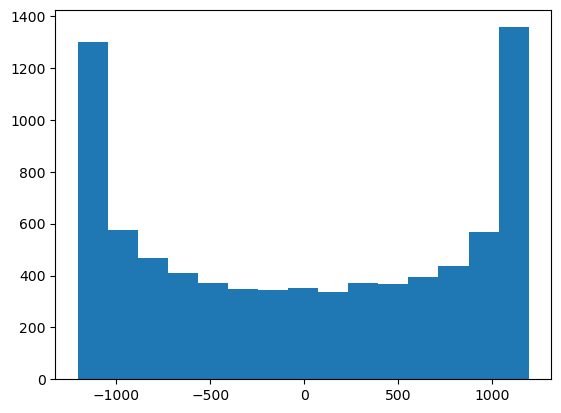

In [220]:
plt.hist(id_cell[56], bins=15);

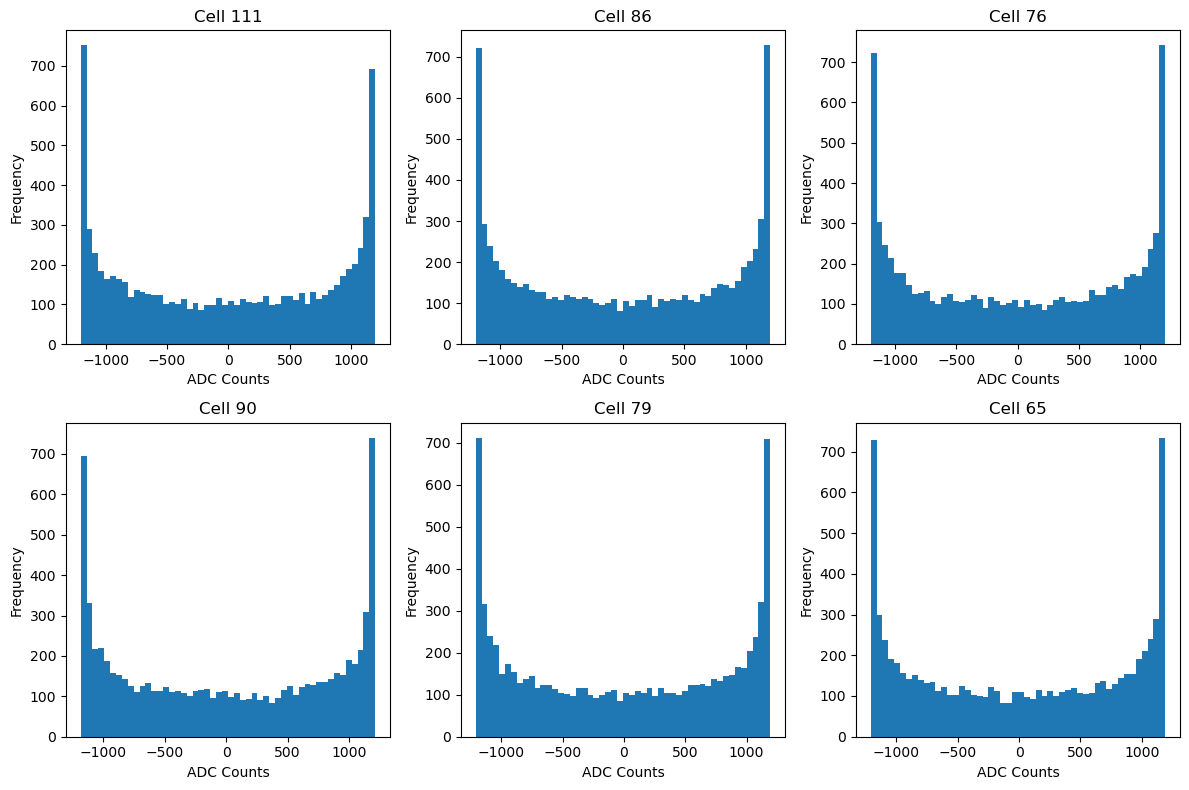

In [221]:
random_indices = np.random.choice(128, 6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Plot the histograms for the randomly selected indices
for i, idx in enumerate(random_indices):
    axes[i].hist(id_cell[idx], bins=50)
    axes[i].set_title(f"Cell {idx}")
    axes[i].set_xlabel('ADC Counts')
    axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

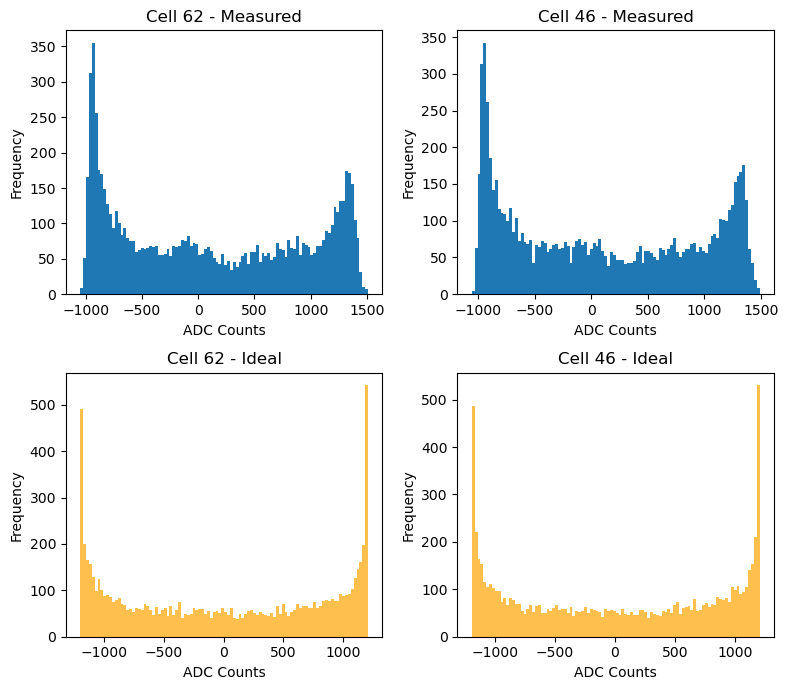

In [222]:
random_indices = np.random.choice(128, 2, replace=False)
fig, axes = plt.subplots(2, 2, figsize=(8, 7))

# Plot the histograms
for i, idx in enumerate(random_indices):
    
    axes[0, i].hist(cell_data[idx], bins=100)
    axes[0, i].set_title(f"Cell {idx} - Measured")
    axes[0, i].set_xlabel('ADC Counts')
    axes[0, i].set_ylabel('Frequency')

    axes[1, i].hist(id_cell[idx], bins=100, color='orange', alpha=0.7)
    axes[1, i].set_title(f"Cell {idx} - Ideal")
    axes[1, i].set_xlabel('ADC Counts')
    axes[1, i].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Let's try to implement a function that transforms the output of my sinewave and see how the distribution transforms

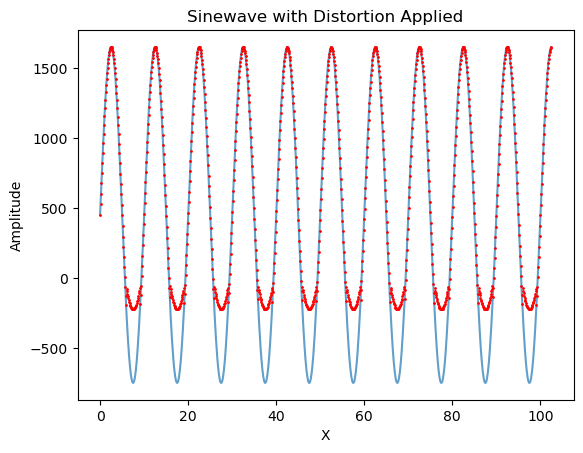

In [223]:
def distortion(x, threshold=-200, factor=0.3):
    distorted_x = np.where(x < threshold,  factor * x, x)  
    return distorted_x

# Example Usage
x = np.linspace(0, 102.4, 1024)
y_input = sinewave(x, 1200, 0.1, 0, 450)

y_distorted = distortion(y_input)

plt.plot(x, y_input, label="Original Sinewave", alpha=0.7)
plt.plot(x, y_distorted, '.',label="Distorted Sinewave", markersize=2, color="red")
plt.xlabel("X")
plt.ylabel("Amplitude")
plt.title("Sinewave with Distortion Applied")
plt.show()

In [224]:
y_prime = np.zeros((1000, 128, 8))

# Generate sine waves and store them in the array
for i, phi in enumerate(phi_values):
    sine = sinewave(x, 1200,  0.100, phi, 450)  # Generate sine wave
    output = distortion(sine)
    y_prime[i] = output.reshape(8, 128).T  # Reshape and store

print(y_prime.shape)
print(phi_values.shape)

(1000, 128, 8)
(1000,)


In [225]:
dist_cell = np.zeros((128, 8000))
for i in range(128):
    dist_cell[i] = y_prime[:,i,:].flatten()
print(dist_cell.shape)

(128, 8000)


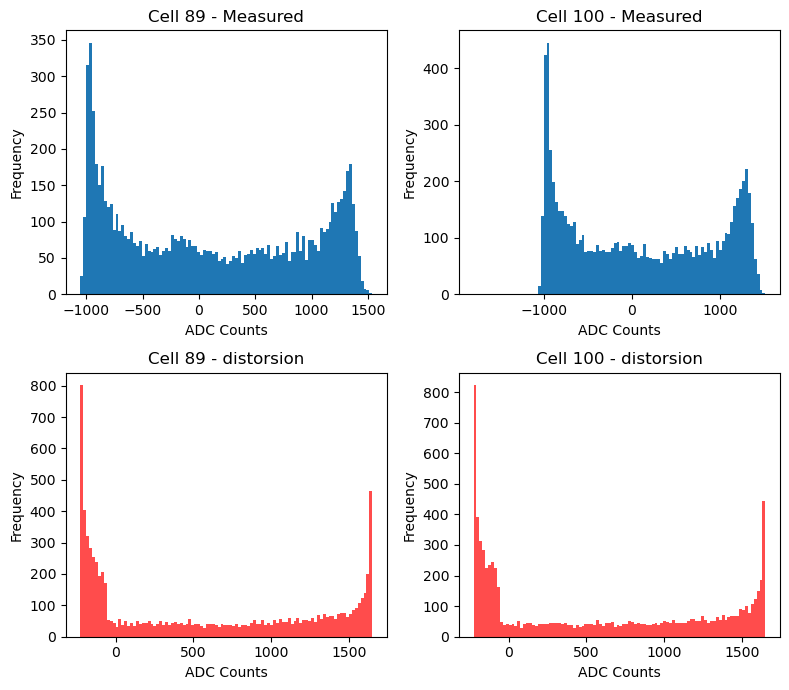

In [226]:
random_indices = np.random.choice(128, 2, replace=False)
fig, axes = plt.subplots(2, 2, figsize=(8, 7))

# Plot the histograms
for i, idx in enumerate(random_indices):
    
    axes[0, i].hist(cell_data[idx], bins=100)
    axes[0, i].set_title(f"Cell {idx} - Measured")
    axes[0, i].set_xlabel('ADC Counts')
    axes[0, i].set_ylabel('Frequency')

    axes[1, i].hist(dist_cell[idx], bins=100, color='red', alpha=0.7)
    axes[1, i].set_title(f"Cell {idx} - distorsion")
    axes[1, i].set_xlabel('ADC Counts')
    axes[1, i].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()